In [1]:

import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
df=pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
notF = df[df.isFraud == 0].sample(8213)
isF = df[df.isFraud == 1]

In [9]:
newDf = pd.concat([isF, notF]).sort_index()
newDf.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5183665,360,PAYMENT,9426.82,C1521867995,0.00,0.00,M1617141794,0.00,0.00,0,0
5505222,380,CASH_OUT,28448.26,C1189066492,0.00,0.00,C634389298,108658.78,137107.04,0,0
6291212,662,CASH_OUT,1468304.35,C1130194242,1468304.35,0.00,C1082598322,0.00,1468304.35,1,0
6117710,530,DEBIT,3267.79,C278363687,10738.00,7470.21,C1963906053,35249.56,38517.35,0,0
1511368,151,TRANSFER,127091.33,C1183499119,127091.33,0.00,C1668573302,0.00,0.00,1,0


In [10]:
newDf.shape

(16426, 11)

In [11]:
newDf['isFraud'].value_counts()

isFraud
1    8213
0    8213
Name: count, dtype: int64

In [12]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  object 
 2   amount          16426 non-null  float64
 3   nameOrig        16426 non-null  object 
 4   oldbalanceOrg   16426 non-null  float64
 5   newbalanceOrig  16426 non-null  float64
 6   nameDest        16426 non-null  object 
 7   oldbalanceDest  16426 non-null  float64
 8   newbalanceDest  16426 non-null  float64
 9   isFraud         16426 non-null  int64  
 10  isFlaggedFraud  16426 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.5+ MB


In [13]:
newDf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,16426.0,3.067537e+02,1.935322e+02,1.0,161.0000,283.000,4.090000e+02,7.430000e+02
amount,16426.0,8.266106e+05,1.886412e+06,0.0,37119.5800,172589.760,5.395396e+05,4.224248e+07
oldbalanceOrg,16426.0,1.254100e+06,3.302755e+06,0.0,10352.5175,117345.350,7.909177e+05,5.958504e+07
newbalanceOrig,16426.0,5.370777e+05,2.573044e+06,0.0,0.0000,0.000,0.000000e+00,4.958504e+07
oldbalanceDest,16426.0,8.175725e+05,3.133881e+06,0.0,0.0000,0.000,5.279172e+05,2.362305e+08
newbalanceDest,16426.0,1.248794e+06,3.623470e+06,0.0,0.0000,124478.025,1.085866e+06,2.367265e+08
isFraud,16426.0,5.000000e-01,5.000152e-01,0.0,0.0000,0.500,1.000000e+00,1.000000e+00
isFlaggedFraud,16426.0,9.740655e-04,3.119577e-02,0.0,0.0000,0.000,0.000000e+00,1.000000e+00


In [14]:
newDf['type'].value_counts() 

type
CASH_OUT    7011
TRANSFER    4775
PAYMENT     2803
CASH_IN     1785
DEBIT         52
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='amount'>

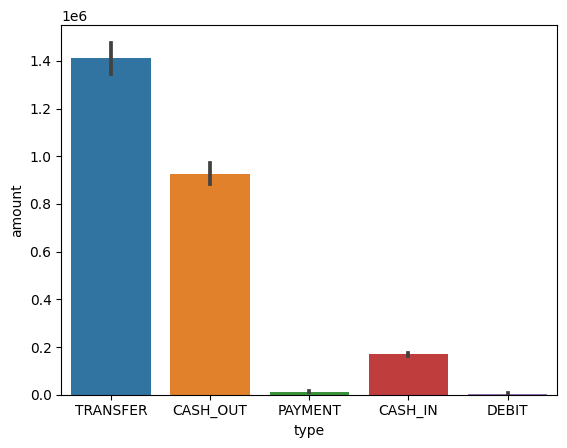

In [15]:
sns.barplot(x='type',y='amount', data=newDf) 

<Axes: xlabel='amount', ylabel='step'>

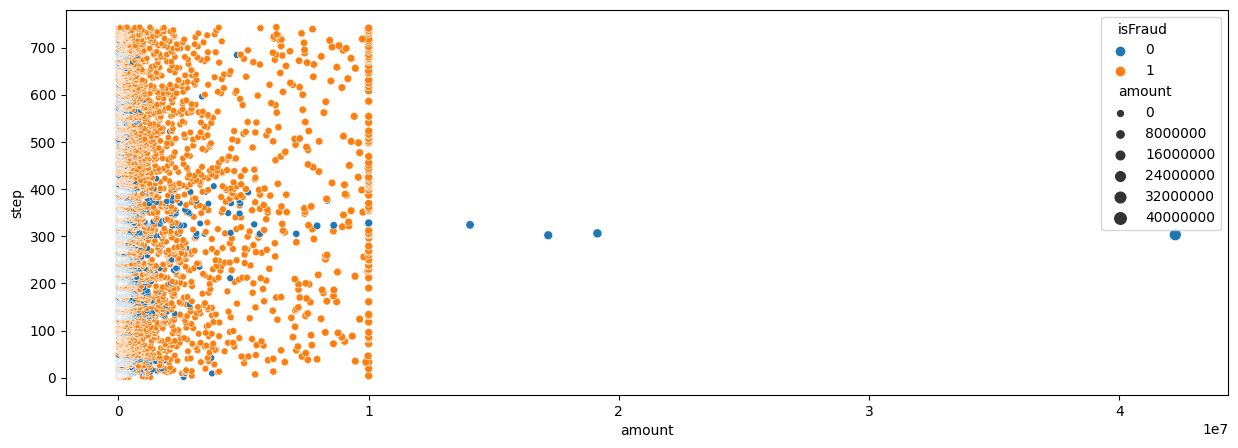

In [16]:

plt.figure(figsize=(15,5))
sns.scatterplot(data=newDf,x='amount',y='step',hue='isFraud',size='amount')

<Axes: xlabel='oldbalanceOrg', ylabel='newbalanceDest'>

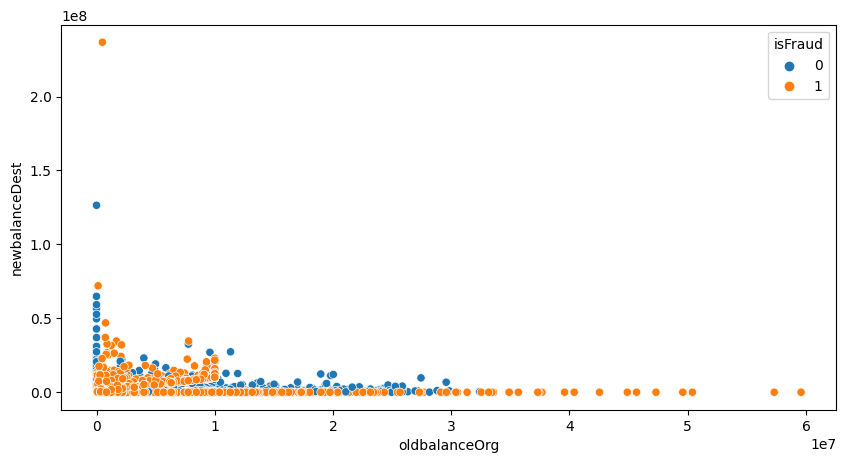

In [17]:

plt.figure(figsize=(10,5))
sns.scatterplot(data=newDf,x='oldbalanceOrg',y='newbalanceDest',hue='isFraud')

In [18]:
CrosstabResult=pd.crosstab(index=newDf.type,columns=df.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1785,0
CASH_OUT,2895,4116
DEBIT,52,0
PAYMENT,2803,0
TRANSFER,678,4097


<Axes: xlabel='type'>

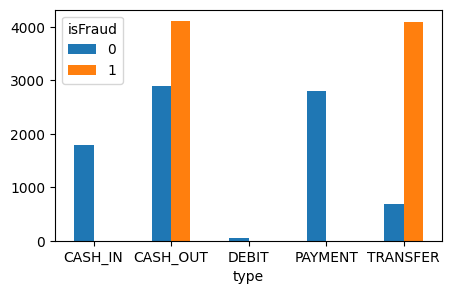

In [19]:

CrosstabResult.plot.bar(figsize=(5,3), rot=0)

In [20]:
CrossTab_step= pd.crosstab(index=newDf.step,columns=df.isFraud).sort_values(by=1, ascending=False).head(5)
CrossTab_step

isFraud,0,1
step,,
212,47,40
523,0,30
387,0,28
501,0,28
730,0,28


<Axes: xlabel='step'>

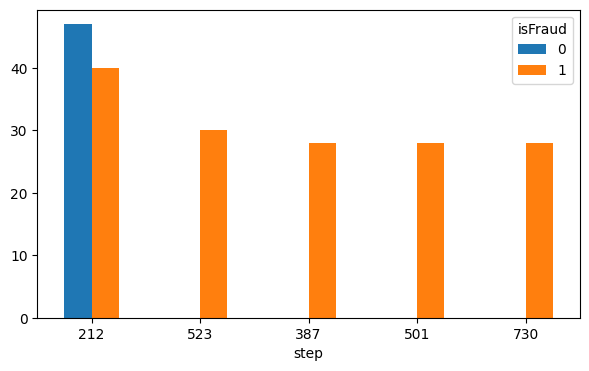

In [21]:

CrossTab_step.plot.bar(figsize=(7,4), rot=0)

In [22]:
df_1 = pd.get_dummies(newDf,columns=['type'])
df_1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,False,False,False,False,True
3,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,False,True,False,False,False
251,1,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,False,False,False,False,True
252,1,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,False,True,False,False,False
680,1,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,False,False,False,False,True


In [23]:
df_1=df_1.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)

In [24]:


X = df_1.loc[:, df_1.columns!= 'isFraud']
y = df_1.loc[:, df_1.columns== 'isFraud']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [26]:
model = svm.SVC(kernel='rbf',C=30)
model.fit(X_train,y_train)
model.score(X_test, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9015827922077922

In [27]:
model1=LogisticRegression(solver='liblinear',multi_class='ovr',random_state=42)
model1.fit(X_train,y_train)
model1.score(X_test,y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.903814935064935

In [28]:
model2=RandomForestClassifier(n_estimators=5)
model2.fit(X_train,y_train)
model2.score(X_test,y_test)

/tmp/ipykernel_33/2939213960.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2.fit(X_train,y_train)


0.9884334415584416

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
model_pred_test = model.predict(X_test)
accuracy_score(y_test, model_pred_test)

0.9015827922077922

In [31]:
conf_matrix = confusion_matrix(y_test, model_pred_test)
conf_matrix

array([[2390,   67],
       [ 418, 2053]])

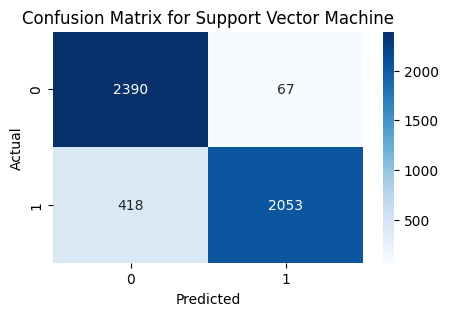

In [32]:

plt.figure(figsize=(5,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

In [33]:
print(classification_report(y_test, model_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2457
           1       0.97      0.83      0.89      2471

    accuracy                           0.90      4928
   macro avg       0.91      0.90      0.90      4928
weighted avg       0.91      0.90      0.90      4928



In [34]:
model1_pred_test = model1.predict(X_test) 
accuracy_score(y_test, model1_pred_test)

0.903814935064935

In [35]:
conf_matrix1 = confusion_matrix(y_test,model1_pred_test)
conf_matrix1

array([[2259,  198],
       [ 276, 2195]])

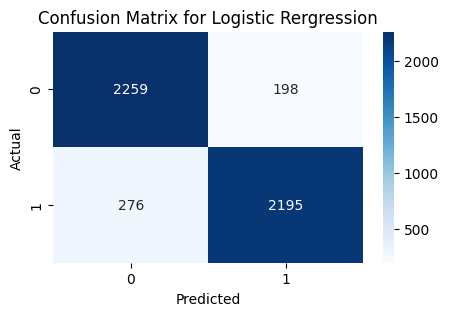

In [36]:
plt.figure(figsize=(5,3))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Rergression')
plt.show()

In [37]:
print(classification_report(y_test, model1_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2457
           1       0.92      0.89      0.90      2471

    accuracy                           0.90      4928
   macro avg       0.90      0.90      0.90      4928
weighted avg       0.90      0.90      0.90      4928



In [38]:
model2_pred_test = model2.predict(X_test) 
accuracy_score(y_test, model2_pred_test)

0.9884334415584416

In [39]:
conf_matrix2 = confusion_matrix(y_test, model2_pred_test)
conf_matrix2

array([[2422,   35],
       [  22, 2449]])

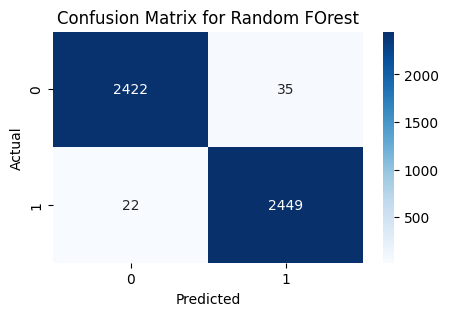

In [40]:
# Plotting the confusion matrix
plt.figure(figsize=(5,3))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random FOrest')
plt.show()

In [41]:
print(classification_report(y_test, model2_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2457
           1       0.99      0.99      0.99      2471

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [42]:
X1 = df_1.loc[:, df_1.columns!= 'isFraud']
y1 = np.squeeze(df_1.loc[:, df_1.columns== 'isFraud'])


In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

In [44]:


model_params = {
    'svm': {
        'model': svm.SVC(),
        'params' : {
            'C': [10,20,30],
            'kernel': ['rbf'],
            'gamma' : ['scale','auto']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(),
        'params': {
            'solver' : ['liblinear','lbfgs'],
           'multi_class' : ['auto','ovr'],
            'C': [1,5,10]
        }
    }
}

In [45]:


scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X1_train,y1_train)
    clf.score(X1_test, y1_test)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [46]:


df_new = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_new

,model,best_score,best_params
0,svm,0.903722,"{'C': 30, 'gamma': 'scale', 'kernel': 'rbf'}"
1,random_forest,0.986519,{'n_estimators': 5}
2,logistic_regression,0.911375,"{'C': 1, 'multi_class': 'auto', 'solver': 'lib..."
